In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import iqr, zscore,norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

In [3]:
# Load the House Price Dataset
housing_df = pd.read_excel("HousePricing_Linear Regression.xlsx",sheet_name=0)
housing_df.head()

,price,sqft_living,bedrooms,bathrooms,floors
0,221900,1180,3,1.00,1.0
1,538000,2570,3,2.25,2.0
2,180000,770,2,1.00,1.0
3,604000,1960,4,3.00,1.0
4,510000,1680,3,2.00,1.0


# Above Data file containes below features.

1. price: Price is prediction target
1. bedrooms: Number of Bedrooms/House
1. bathrooms: Number of bathrooms/bedrooms
1. sqft_living: square footage of the home
1. floors: Total floors (levels) in house

## Explodatory Data Analysis (EDA)

In [4]:
#5 Point Summary

housing_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,21613.0,540088.141905,367127.195968,75000.0,321950.00,450000.00,645000.0,7700000.0
sqft_living,21613.0,2079.899736,918.440897,290.0,1427.00,1910.00,2550.0,13540.0
bedrooms,21613.0,3.370842,0.930062,0.0,3.00,3.00,4.0,33.0
bathrooms,21613.0,2.114757,0.770163,0.0,1.75,2.25,2.5,8.0
floors,21613.0,1.494309,0.539989,1.0,1.00,1.50,2.0,3.5


#### Null value check

    We do not have null value in any of above feature,where as we have 0 values.
    We should impute these 0 values, depending on feature.



In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21613 non-null  int64  
 1   sqft_living  21613 non-null  int64  
 2   bedrooms     21613 non-null  int64  
 3   bathrooms    21613 non-null  float64
 4   floors       21613 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 844.4 KB


### 1.Missing data analysis

Important questions when thinking about missing data:

    How prevalent is the missing data?
    Is missing data random or does it have a pattern?

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.


In [6]:
#missing data => Find total rows having missing values and calculate the percentage of missing values for each field.
total = housing_df.isnull().sum().sort_values(ascending=False)
percent = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
floors,0,0.0
bathrooms,0,0.0
bedrooms,0,0.0
sqft_living,0,0.0
price,0,0.0


In [7]:
# Lets analyse zero values

for col in housing_df.columns:
    if housing_df[col].dtypes == 'int64' or housing_df[col].dtypes == 'float64':
        if np.count_nonzero(housing_df[col]==0):
            print('Number of 0-entries for "{field_name}" feature:{amount}'.format(
                field_name=col,amount=np.count_nonzero(housing_df[col]==0) ))

Number of 0-entries for "bedrooms" feature:13
Number of 0-entries for "bathrooms" feature:10


### Zero value analysis

**Non-considerable zero value in field**

    bedrooms with 13 zero seems missing value,as we can not have house without any bed room.
    bathrooms is having 10 zero values seems missing value,as we can not have house without any bath room.

### 2.Outliers analysis

Outliers is also something that we should be aware of. Why? Because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'price' and a set of scatter plots.


In [8]:
def checkIQR(data):
    print("Attributes for which values lie outside of IQR")
    for field in housing_df.columns:
        if housing_df[field].dtypes == 'int64' or housing_df[field].dtypes == 'float64':
            Q1 = data[field].quantile(0.25)
            Q3 = data[field].quantile(0.75)
            current_iqr = iqr(data[field], rng=(25,75), interpolation='midpoint')
            iqr_analysis = (data[field] < (Q1 - 1.5 * current_iqr)) |(data[field] > (Q3 + 1.5 * current_iqr))
            if (iqr_analysis == True).any() == True:
                print('{field_name} : {flag}'.format(field_name=field,flag=sum(iqr_analysis)))
checkIQR(housing_df)

Attributes for which values lie outside of IQR
price : 1146
sqft_living : 572
bedrooms : 546
bathrooms : 571


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='bathrooms'>

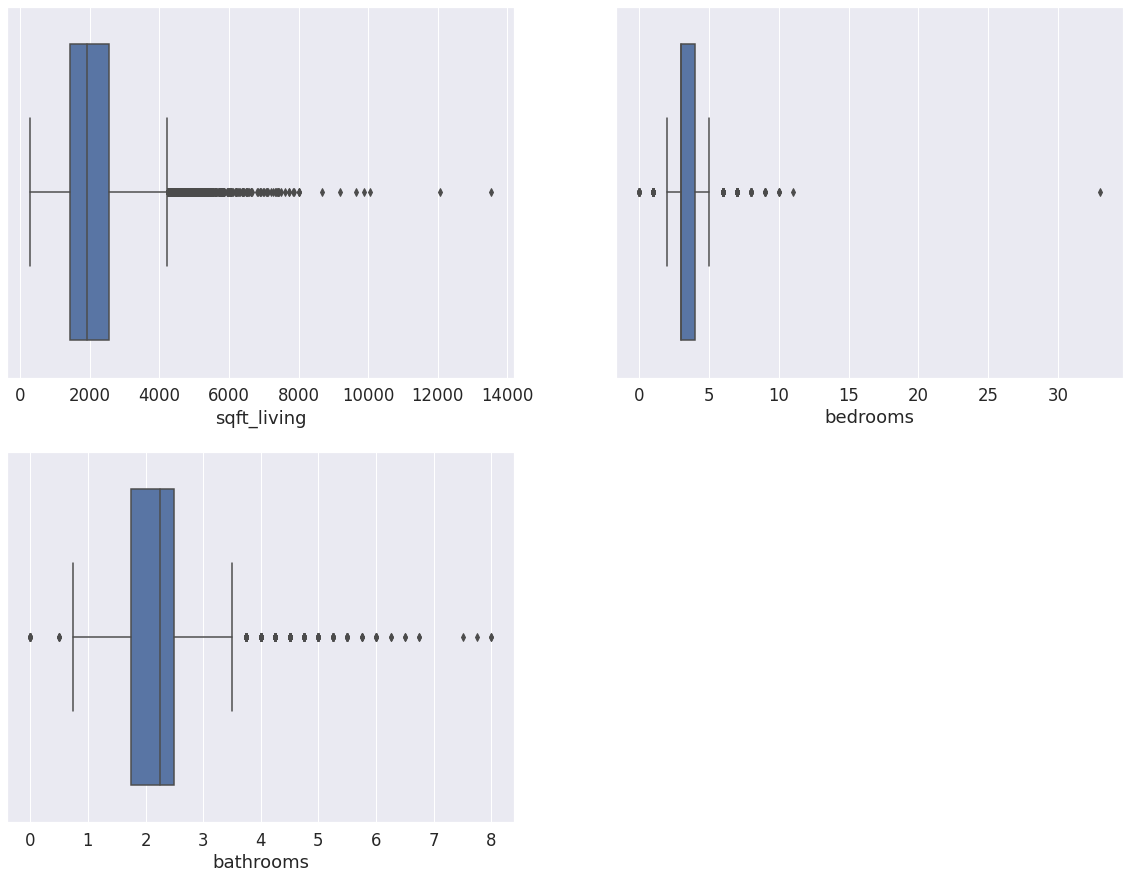

In [11]:
# Box plot to see outliers pattern in the data. 

fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig1 = fig.add_subplot(221); 
sns.boxplot(housing_df.sqft_living, data=housing_df)

fig2 = fig.add_subplot(222); 
sns.boxplot(housing_df.bedrooms, data=housing_df)

fig3 = fig.add_subplot(223); 
sns.boxplot(housing_df.bathrooms, data=housing_df)


### Distribution analysis

we have created below columns to understand the distribution of data.
1. types - data type of the feature.
2. counts - total count of records for that feature.
3. distincts - total number of distinct value for that feature.
4. uniques - all unique values in that feature.
5. skewness - skewness of the data for all features.
6. kurtosis - meaure of tailedness from the data for all features.
7. corr_price - correlation of each feature with target variable 'price'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='price'>

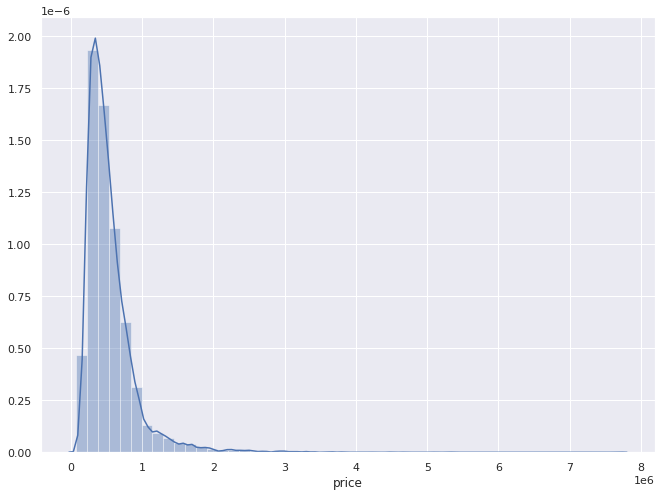

In [14]:
sns.set(rc={'figure.figsize': (11, 8)})
sns.distplot(housing_df['price'],hist=True, kde=True)

Skewness is a measure of the symmetry in a distribution.
It measures the amount of probability in the tails.

The value is often compared to the kurtosis of the normal distribution, which is equal to 3.

If the kurtosis is greater than 3, then the dataset has heavier tails than a normal distribution


In [15]:
print("Skewness: %f" % housing_df['price'].skew())
print("Kurtosis: %f" % housing_df['price'].kurt())

Skewness: 4.024069
Kurtosis: 34.585540


In [16]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, uniques, skewness, kurtosis, corr], axis = 1)
        corr_col = 'corr_'  + pred
        cols = ['types', 'counts', 'distincts','uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\n')
    print('Data types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [17]:
details = rstr(housing_df, 'price')
display(details.sort_values(by='corr_price', ascending=False))

Data shape: (21613, 5)
___________________________

Data types:
 int64      3
float64    2
Name: types, dtype: int64
___________________________


,types,counts,distincts,uniques,skewness,kurtosis,corr_price
price,int64,21613,4032,"[[221900.0, 538000.0, 180000.0, 604000.0, 5100...",4.024,34.586,1.000
sqft_living,int64,21613,1038,"[[1180.0, 2570.0, 770.0, 1960.0, 1680.0, 5420....",1.472,5.243,0.702
bathrooms,float64,21613,30,"[[1.0, 2.25, 3.0, 2.0, 4.5, 1.5, 2.5, 1.75, 2....",0.511,1.280,0.525
bedrooms,int64,21613,13,"[[3.0, 2.0, 4.0, 5.0, 1.0, 6.0, 7.0, 0.0, 8.0,...",1.974,49.064,0.308
floors,float64,21613,6,"[[1.0, 2.0, 1.5, 3.0, 2.5, 3.5]]",0.616,-0.485,0.257


The dependent variabel, price, are skewed and heavy-tailed distribution. We need investigate its distribution with the plots and check if a transformation by Log 1P could correct it, without dropping most of the outiliers.

## 3. Correlation Analysis
correlation coefficient measures a degree of relation between two variables, it only measures the linear relationship between the variables.

A correlation of -1.0 shows a perfect negative correlation, while a correlation of 1.0 shows a perfect positive

A correlation of 0.0 shows zero or no relationship between the movement of the two variables.
From above stats we saw skewness and correlation of fields with price.

Let's understand the correlation from heatmap. This heatmap is the best way to get a quick overview to understand the relationship between dependent and independent variable.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

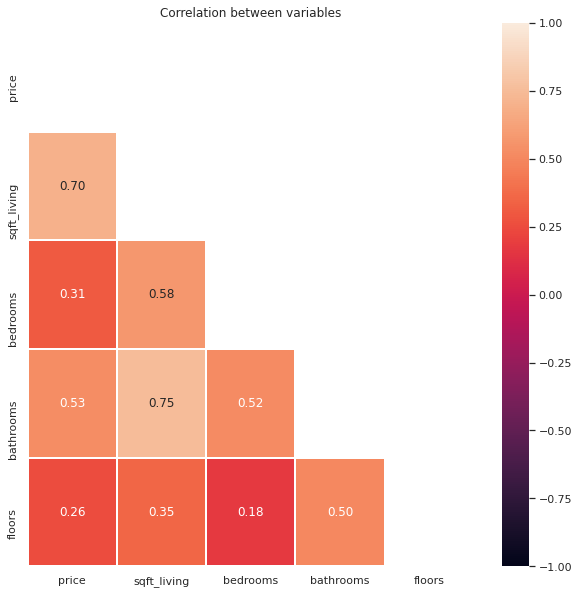

In [22]:
housing_df_drop = housing_df
corr = housing_df_drop.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (10,10))
with sns.axes_style("white"):
    sns.heatmap(corr,annot=True,linewidth=1,mask = mask,vmax=1,vmin=-1,fmt='.2f')
    plt.title("Correlation between variables")
    plt.show()

### Bivariate Analysis

<IPython.core.display.Javascript object>

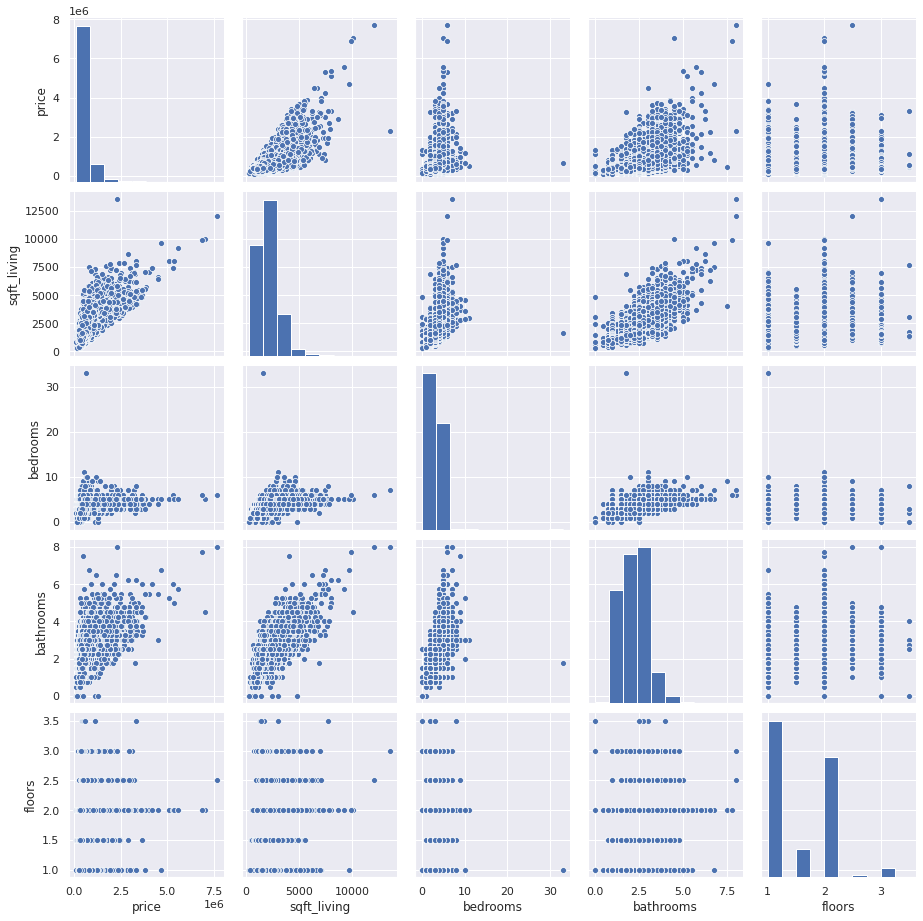

In [27]:
#bivariate analysis price/lot_measure
sns.pairplot(housing_df)

We found good correlation of sqft_living feature with our target feature i.e Price
There are all positive correlation of independent features with target variable

There is strong correlation between Bedrooms and Bathrooms, Bathroom and sqft_living

### Hypothesis testing

    Null Hypothesis:there is a no significant linear relationship between an independent variable and a    dependent   variable
    Ho: Β1 = 0
    Alternate hyothesis: there is a significant linear relationship between an independent variable and a dependent variable
    Ha: Β1 ≠ 0
    In short If we find that the slope of the regression line is significantly different from zero, we will conclude that there is a significant relationship between the independent and dependent variables.The           null hypothesis states that the slope is equal to zero, and the alternative hypothesis states that the slope is not equal to zero

### Linear Regression

In [35]:
X = housing_df.drop({'price'}, axis=1)
y = housing_df[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.27 , random_state=42)

<IPython.core.display.Javascript object>

In [36]:
LRM = LinearRegression().fit(X_train, y_train)
print('Train Score:',LRM.score(X_train, y_train))
print('Test Score: ',LRM.score(X_test, y_test))
print('Intercept: ',LRM.intercept_)

Train Score: 0.5057082442966934
Test Score:  0.5094835043360764
Intercept:  [72030.22311938]


From above modelling, we see linear regression model is givng less accuracy, so we need to verify whether all linear regression assumption are true.